# ML HW6
### 資科工碩 0756166 楊牧樺

Please execute step by step.

## 0. Preparation

### 0.1 Import librarys

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from celluloid import Camera
from IPython.display import HTML

### 0.2 Read data

In [2]:
moon = np.genfromtxt('moon.txt', delimiter=',')
circle = np.genfromtxt('circle.txt', delimiter=',')

In [3]:
def show_data(datas):
    plt.figure()
    plt.scatter(datas[:,0], datas[:,1],alpha=0.5,s=10)
    plt.show()

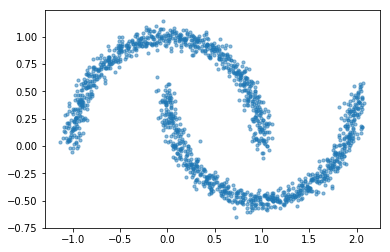

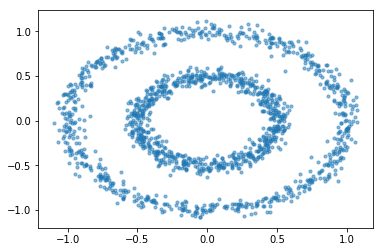

In [4]:
show_data(moon)
show_data(circle)

## 1. Make videos to show the clustering procedure of different methods

Use [celluloid](https://github.com/jwkvam/celluloid/?fbclid=IwAR2Zdqj5XS5tJNWrL5ABXkdfizGf_skoYGj8kOHrovSzq_uP70f9HWphxGI) to make videos to show the clustering procedure.

### 1.1 k-means

<font color="#006666">Step:</font><br /> 
1. randomly pick k data points as centers
2. E-step: classify all samples according to closet μ (use Euclidean distance)
3. M-step: re-compute as the centers of the points in each cluster
4. repeat E-step and M-step until centers is no change

In [5]:
def Euclidean_distance(x,y):
    distance = np.sqrt(np.dot(x**2, np.ones((x.shape[1],y.shape[0]))) \
    + np.dot(np.ones((x.shape[0],x.shape[1])), (y**2).T) \
    - 2*np.dot(x,y.T))
    return distance 

In [6]:
def get_new_mean(datas, cluster, k):
    u=[]
    for i in range(k):
        u.append(datas[cluster == i].mean(axis=0))
    u = np.array(u)
    return u

In [7]:
def kmeans(datas, k, title):
    color_set = ['b', 'g', 'c', 'y']
    m = np.array(random.sample(list(datas), k)) #mean
    fig = plt.figure()
    camera = Camera(fig)
    while True:
        #E step
        d = Euclidean_distance(datas, m)
        cluster = np.argmin(d, axis=1)
        #M step
        update_m = get_new_mean(datas, cluster, k)
        #images
        color=np.array(list(map(str,cluster)))
        for i in range(len(color_set)):
            color[color == str(i)] = color_set[i]
        plt.scatter(datas[:,0], datas[:,1],c=list(color),alpha=0.5,s=10)
        plt.scatter(m[:,0], m[:,1],c='r',alpha=0.5,s=15,marker='X')
        camera.snap()
        #plt.show()
        
        #check over
        if (m == update_m).all():
            break
        
        m = update_m
    #make video
    animation = camera.animate()    
    animation.save('kmeans_'+title+'_k='+str(k)+'.mp4')
    #display(HTML(animation.to_html5_video()))

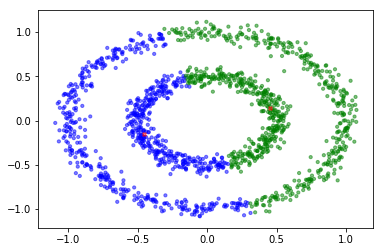

In [8]:
k = 2
kmeans(circle, k, 'circle')

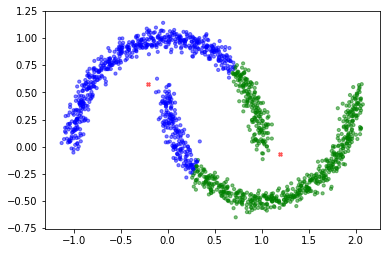

In [9]:
k = 2
kmeans(moon, k, 'moon')

### 1.2 kernel k-means

This algorithm applies the same trick as k-means but with one difference that here in the calculation of distance, kernel method is used instead of the Euclidean distance.  
Convergence is achieved when the new cluster obtained from each iteration does not change with the previous cluster.

[kernel k-means clustering algorithm](https://sites.google.com/site/dataclusteringalgorithms/kernel-k-means-clustering-algorithm)

<font color="#006666">Observed:</font><br />  
* The effect of this method is closely related to initial clustering.  
* The bigger the gamma, the more serious the overfitting. (like random)
* If the gamma is too small, it will become like k-means.


In [7]:
def RBF_kernel(u, v, gamma=5):
    d = Euclidean_distance(u,v)
    result = np.exp(-1 * gamma * d**2)
    where_are_nan = np.isnan(result)
    result[where_are_nan] = 1
    return result

In [8]:
def kernel_distance(gram_matrix, cluster, k):
    
    d = np.zeros((gram_matrix.shape[0], k))
    for c in range(k): 
        term1 = gram_matrix.diagonal()
        term2 = -2 * gram_matrix[cluster == c].mean(axis=0)
        m = (cluster == c).astype(np.int)
        term3 = np.nansum((m * (m * gram_matrix).sum(axis=1))) / (m.sum() ** 2)        
        d[:, c] = term1 + term2 + term3
    
    return d

In [12]:
def kernel_kmeans(datas, k, title, gamma=5):
    gram_matrix = RBF_kernel(datas, datas, gamma) #project data to featured space
    cluster = np.random.randint(0, k, datas.shape[0]) #initial clustering
    
    color_set = ['b', 'g', 'c', 'y']
    fig = plt.figure()
    camera = Camera(fig)
    while True:
        d = kernel_distance(gram_matrix, cluster, k)
        update_c = np.argmin(d, axis=1)
        
        #images
        color=np.array(list(map(str,cluster)))
        for i in range(len(color_set)):
            color[color == str(i)] = color_set[i]
        plt.scatter(datas[:,0], datas[:,1],c=list(color),alpha=0.5,s=10)
        camera.snap()
        #plt.show()
        
        #check over
        if (cluster == update_c).all():
            break
        
        cluster = update_c
    #make video
    animation = camera.animate()    
    animation.save('kernel_kmeans_'+title+'_k='+str(k)+'.mp4')
    #display(HTML(animation.to_html5_video()))

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


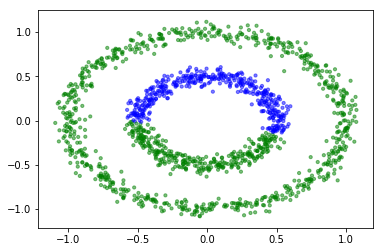

In [84]:
k = 2
kernel_kmeans(circle, k, 'circle',60)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


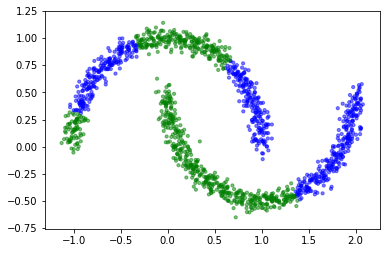

In [91]:
k = 2
kernel_kmeans(moon, k, 'moon',40)

### 1.3 Spectral clustering

[Spectral Clustering](https://towardsdatascience.com/spectral-clustering-aba2640c0d5b?fbclid=IwAR3NTUXzdn6wJeyY8C-neqpjPmbNsUU-wLx4qMKWQVwkFiDmHUw5fw5612k)

<font color="#006666">Step:</font><br />  
1. Get graph laplacian to compute eigen value and eigen vectors.
2. Use the first eigen vectors with the lowest k eigen value to form a new eigen space to represent the original data.
3. Use eigen space U to do k-means.

<font color="#006666">Observed:</font><br />  
* Spectral clustring finds the answer very quickly and works very well.
* Gamma too large leads to overfitting, but too small leads to underfitting

In [114]:
def spectral_clustering(datas, k, title, gamma=5):
    W = RBF_kernel(datas, datas, gamma) #similarity_matrix
    D = np.diag(W.sum(axis=1)) #degree
    L = D - W #graph laplacian
    eigen_values, eigen_vectors = np.linalg.eig(L)
    sorted_idx = np.argsort(eigen_values)
    U = []
    for i in range(k):
        ev = eigen_vectors[:,sorted_idx[i]]
        U.append(ev[:,None])
    U = np.array(U).T[0]
    
    #kmeans
    color_set = ['b', 'g', 'c', 'y']
    cluster = np.random.randint(0, k, datas.shape[0])
    m = get_new_mean(U, cluster, k) #mean
    fig = plt.figure()
    camera = Camera(fig)
    while True:
        #E step
        d = Euclidean_distance(U, m)
        cluster = np.argmin(d, axis=1)
        #M step
        update_m = get_new_mean(U, cluster, k)
        #images
        color=np.array(list(map(str,cluster)))
        for i in range(len(color_set)):
            color[color == str(i)] = color_set[i]
        plt.scatter(datas[:,0], datas[:,1],c=list(color),alpha=0.5,s=10)
        camera.snap()
        #plt.show()
        
        #check over
        if (m == update_m).all():
            break
        
        m = update_m
    #make video
    animation = camera.animate()    
    animation.save('spectral_clustering_'+title+'_k='+str(k)+'.mp4')
    #display(HTML(animation.to_html5_video()))
    

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


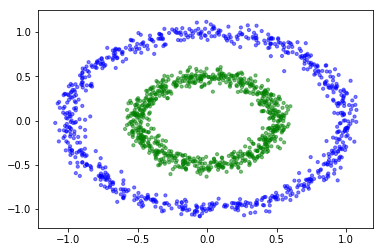

In [115]:
k = 2
spectral_clustering(circle, k, 'circle',30)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


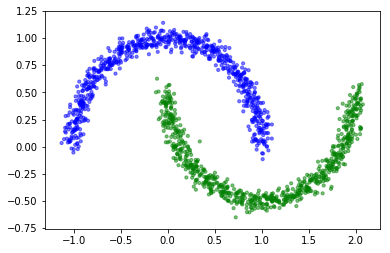

In [116]:
k = 2
spectral_clustering(moon, k, 'moon',20)

### 1.4 DBSCAN

[DBSCAN](https://zh.wikipedia.org/wiki/DBSCAN)

<font color="#006666">Observed:</font><br />
1. Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than MinPts neighbors.
2. Find the connected components of core points on the neighbor graph, ignoring all non-core points.
3. Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

PS: When we make a video, every 200 labelled points will be saved as a photo.

In [73]:
def dbscan(datas, title,eps=0.15, MinPts=5):
    c = 0
    label = np.zeros(datas.shape[0], dtype=int) # 0:unlabel, -1:noise
    d = Euclidean_distance(datas,datas)
    fig = plt.figure()
    camera = Camera(fig)
    color_set = ['b', 'g', 'c', 'y']
    for i in range(datas.shape[0]):
        if label[i] == 0:
            #print(d[i],eps)
            neighbors_index = np.argwhere(d[i] < eps).flatten()
            if neighbors_index.shape[0] < MinPts:
                label[i] = -1
            else:
                c += 1
                label[i] = c
                neighbors_index = neighbors_index[neighbors_index != i]
                while True:
                    ch = 0
                    index = neighbors_index[0]
                    if label[index] == 0:
                        label[index] = c
                        ch = 1
                        new_neighbors = np.argwhere(d[index] < eps).flatten()
                        if new_neighbors.shape[0] >= MinPts:
                            neighbors_index = np.append(neighbors_index,new_neighbors)
                    elif label[index] == -1:
                        label[index] = c
                        ch = 1

                    if np.sum(label>0) % 200 == 0 and ch == 1:
                        
                        cluster = label+1
                        color=np.array(list(map(str,cluster)))
                        for i in range(len(color_set)):
                            color[color == str(i)] = color_set[i]
                        plt.scatter(datas[:,0], datas[:,1],c=list(color),alpha=0.5,s=10)
                        camera.snap()
                        #plt.show()

                    if neighbors_index.shape[0] == 1:
                        break
                    neighbors_index = neighbors_index[1:]
    cluster = label+1
    color=np.array(list(map(str,cluster)))
    for i in range(len(color_set)):
        color[color == str(i)] = color_set[i]
    plt.scatter(datas[:,0], datas[:,1],c=list(color),alpha=0.5,s=10)
    camera.snap()
                    
    animation = camera.animate()    
    animation.save('dbscan_'+title+'.mp4')
                
                        

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


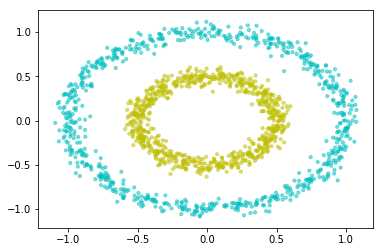

In [74]:
dbscan(circle, 'circle')

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


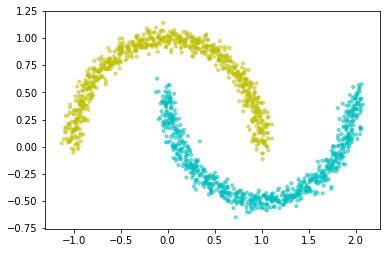

In [75]:
dbscan(moon, 'moon')

## 2. Try more clusters and show results

### 2.1 k-means

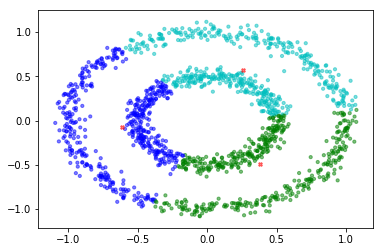

In [21]:
k = 3
kmeans(circle, k, 'circle')

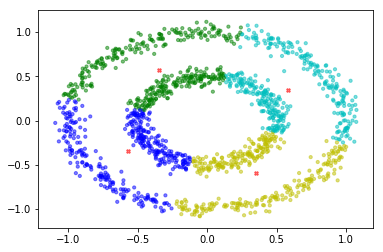

In [22]:
k = 4
kmeans(circle, k, 'circle')

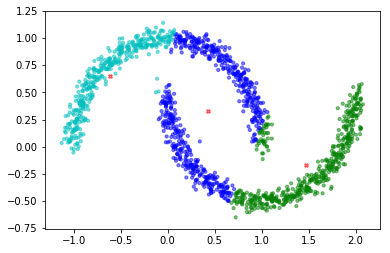

In [23]:
k = 3
kmeans(moon, k, 'moon')

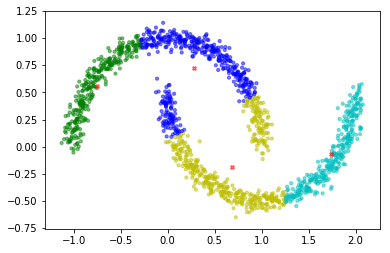

In [24]:
k = 4
kmeans(moon, k, 'moon')

### 2.2 kernel k-means

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


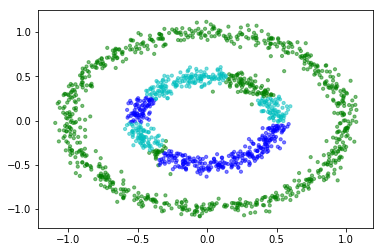

In [25]:
k = 3
kernel_kmeans(circle, k, 'circle',80)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


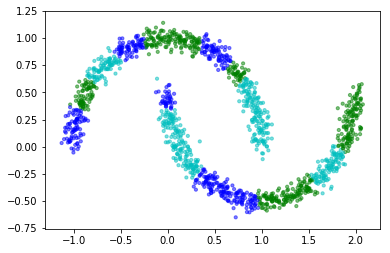

In [26]:
k = 3
kernel_kmeans(moon, k, 'moon',80)

### 2.3 Spectral clustering

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


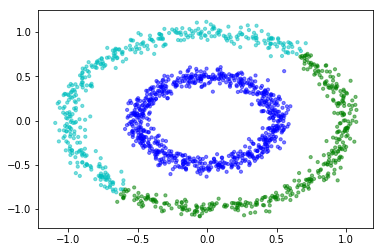

In [27]:
k = 3
spectral_clustering(circle, k, 'circle',30)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


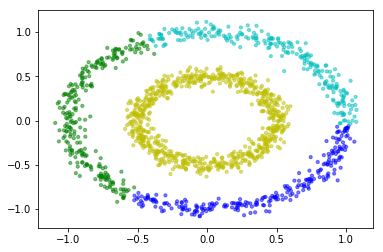

In [28]:
k = 4
spectral_clustering(circle, k, 'circle',30)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


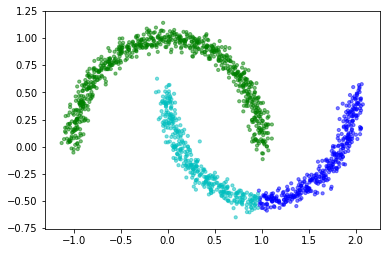

In [29]:
k = 3
spectral_clustering(moon, k, 'moon',30)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


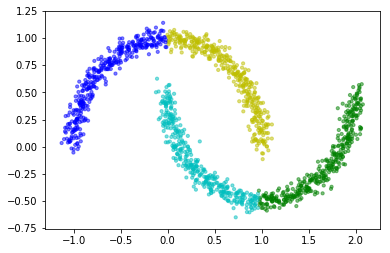

In [30]:
k = 4
spectral_clustering(moon, k, 'moon',30)

## 3. Different initialization method

Here use [k-means++](https://blog.csdn.net/google19890102/article/details/53284285) to produce initial centers and initial cluster as alternative random initialization.

### 3.0 Define the k-means++ initialization method

In [30]:
def kmpp(datas, k):
    m = np.array(random.sample(list(datas), 1)) #mean
    
    for i in range(k-1):
        distance = Euclidean_distance(datas, m)
        closest_distance = distance.min(axis=1)
        probability = closest_distance / closest_distance.sum()
        where_are_nan = np.isnan(probability)
        probability[where_are_nan] = 0
        new_m = datas[np.random.choice(datas.shape[0], p=probability)]
        m = np.vstack((m, new_m))
    d = Euclidean_distance(datas, m)
    cluster = np.argmin(d, axis=1)
    return m, cluster

### 3.1 k-means

In [10]:
def kmeans_kmpp(datas, k, title):
    color_set = ['b', 'g', 'c', 'y']
    m, cluster = kmpp(datas, k)
    fig = plt.figure()
    camera = Camera(fig)
    while True:
        #E step
        d = Euclidean_distance(datas, m)
        cluster = np.argmin(d, axis=1)
        #M step
        update_m = get_new_mean(datas, cluster, k)
        #images
        color=np.array(list(map(str,cluster)))
        for i in range(len(color_set)):
            color[color == str(i)] = color_set[i]
        plt.scatter(datas[:,0], datas[:,1],c=list(color),alpha=0.5,s=10)
        plt.scatter(m[:,0], m[:,1],c='r',alpha=0.5,s=15,marker='X')
        camera.snap()
        #plt.show()
        
        #check over
        if (m == update_m).all():
            break
        
        m = update_m
    #make video
    animation = camera.animate()    
    animation.save('kmeans_kmpp_'+title+'_k='+str(k)+'.mp4')
    #display(HTML(animation.to_html5_video()))
    

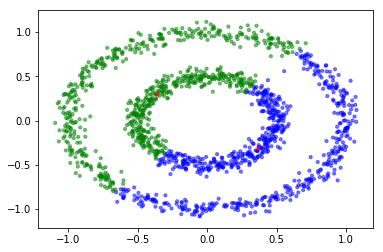

In [11]:
k = 2
kmeans_kmpp(circle, k, 'circle')

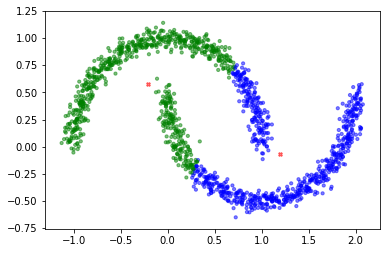

In [12]:
k = 2
kmeans_kmpp(moon, k, 'moon')

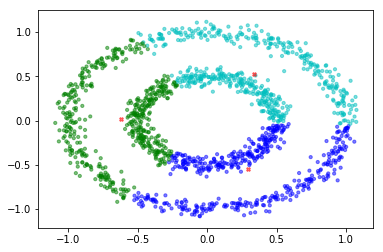

In [13]:
k = 3
kmeans_kmpp(circle, k, 'circle')

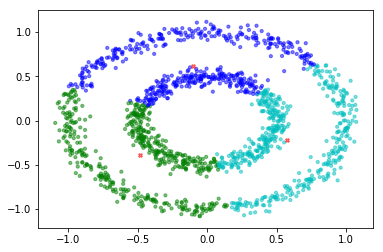

In [14]:
k = 3
kmeans_kmpp(circle, k, 'circle')

### 3.2 kernel k-means

In [15]:
def kernel_kmeans_kmpp(datas, k, title, gamma=5):
    gram_matrix = RBF_kernel(datas, datas, gamma)
    #cluster = np.random.randint(0, k, datas.shape[0])
    m, cluster = kmpp(datas, k)
    color_set = ['b', 'g', 'c', 'y']
    fig = plt.figure()
    camera = Camera(fig)
    while True:
        d = kernel_distance(gram_matrix, cluster, k)
        update_c = np.argmin(d, axis=1)
        
        #images
        color=np.array(list(map(str,cluster)))
        for i in range(len(color_set)):
            color[color == str(i)] = color_set[i]
        plt.scatter(datas[:,0], datas[:,1],c=list(color),alpha=0.5,s=10)
        camera.snap()
        #plt.show()
        
        #check over
        if (cluster == update_c).all():
            break
        
        cluster = update_c
    #make video
    animation = camera.animate()    
    animation.save('kernel_kmeans_kmpp_'+title+'_k='+str(k)+'.mp4')
    #display(HTML(animation.to_html5_video()))

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


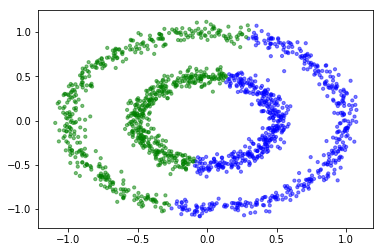

In [16]:
k = 2
kernel_kmeans_kmpp(circle, k, 'circle',60)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


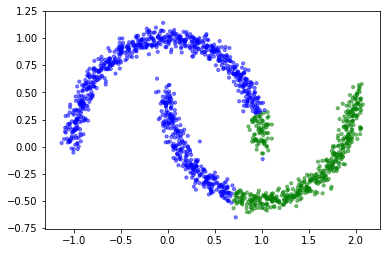

In [22]:
k = 2
kernel_kmeans_kmpp(moon, k, 'moon',60)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


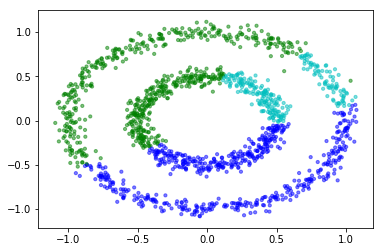

In [19]:
k = 3
kernel_kmeans_kmpp(circle, k, 'circle',60)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


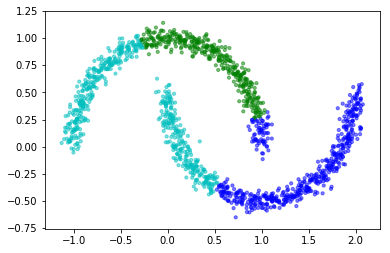

In [23]:
k = 3
kernel_kmeans_kmpp(moon, k, 'moon',60)

### 3.3 Spectral clustering

In [117]:
def spectral_clustering_kmpp(datas, k, title, gamma=5):
    W = RBF_kernel(datas, datas, gamma) #similarity_matrix
    D = np.diag(W.sum(axis=1))
    L = D - W
    eigen_values, eigen_vectors = np.linalg.eig(L)
    sorted_idx = np.argsort(eigen_values)
    U = []
    for i in range(k):
        ev = eigen_vectors[:,sorted_idx[i]]
        U.append(ev[:,None])
    U = np.array(U).T[0]
    
    #kmeans
    color_set = ['b', 'g', 'c', 'y']
    #cluster = np.random.randint(0, k, datas.shape[0])
    #m = get_new_mean(U, cluster, k) #mean
    _, cluster = kmpp(U, k)
    m = get_new_mean(U, cluster, k) #mean
    fig = plt.figure()
    camera = Camera(fig)
    while True:
        #E step
        d = Euclidean_distance(U, m)
        cluster = np.argmin(d, axis=1)
        #M step
        update_m = get_new_mean(U, cluster, k)
        #images
        color=np.array(list(map(str,cluster)))
        for i in range(len(color_set)):
            color[color == str(i)] = color_set[i]
        plt.scatter(datas[:,0], datas[:,1],c=list(color),alpha=0.5,s=10)
        camera.snap()
        #plt.show()
        
        #check over
        if (m == update_m).all():
            break
        
        m = update_m
    #make video
    animation = camera.animate()    
    animation.save('spectral_clustering_kmpp_'+title+'_k='+str(k)+'.mp4')
    #display(HTML(animation.to_html5_video()))
    

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


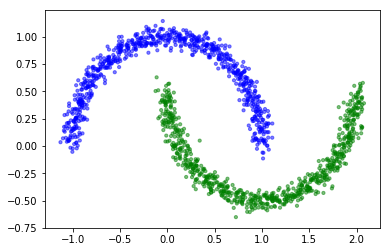

In [118]:
k = 2
spectral_clustering_kmpp(moon, k, 'moon',50)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


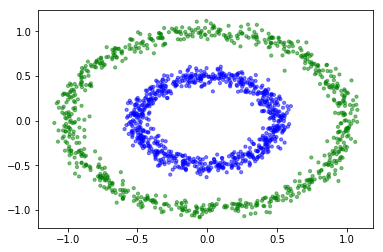

In [119]:
k = 2
spectral_clustering_kmpp(circle, k, 'circle',30)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


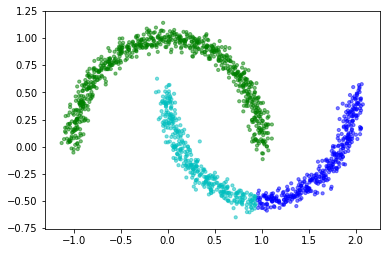

In [120]:
k = 3
spectral_clustering_kmpp(moon, k, 'moon',50)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


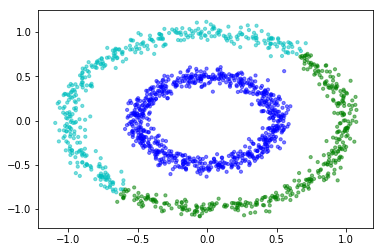

In [121]:
k = 3
spectral_clustering_kmpp(circle, k, 'circle',30)

## 4. Eigen space visualization in spectral clustering

The graph on left hand side show the eigen space composed of eigen vector. You can see that the same group will have similar coordinates, which will allow the later k-means to separate the correct group.  
The graph of right hand side show the first ten eigen value, two points at y=0 means that there is two connected components in the graph, so we can choose k=2 depending on this information. 

In [122]:
def spectral_clustering_showClustering(datas, k=2, gamma=5):
    W = RBF_kernel(datas, datas, gamma) #similarity_matrix
    D = np.diag(W.sum(axis=1))
    L = D - W
    eigen_values, eigen_vectors = np.linalg.eig(L)
    sorted_idx = np.argsort(eigen_values)
    U = []
    for i in range(k):
        ev = eigen_vectors[:,sorted_idx[i]]
        U.append(ev[:,None])
    U = np.array(U).T[0]
    
    #kmeans
    color_set = ['b', 'g', 'c', 'y']
    cluster = np.random.randint(0, k, datas.shape[0])
    m = get_new_mean(U, cluster, k) #mean
    
    
    while True:
        #E step
        d = Euclidean_distance(U, m)
        cluster = np.argmin(d, axis=1)
        #M step
        update_m = get_new_mean(U, cluster, k)
        #check over
        if (m == update_m).all():
            break
        
        m = update_m
    #images
    color=np.array(list(map(str,cluster)))
    for i in range(len(color_set)):
        color[color == str(i)] = color_set[i]
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.scatter(U[:,0], U[:,1],c=list(color),alpha=0.5,s=10)
    plt.title('Eigen vectors ')
    plt.subplot(1,2,2)
    plt.plot(eigen_values[:8],'o')
    plt.title('Eigen value ')
    plt.show()
    

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


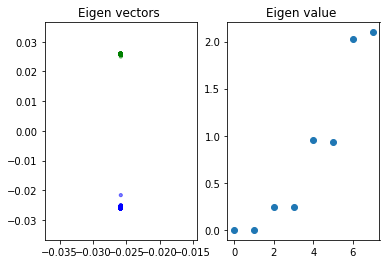

In [123]:
spectral_clustering_showClustering(moon,2,50)

/home/muhua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


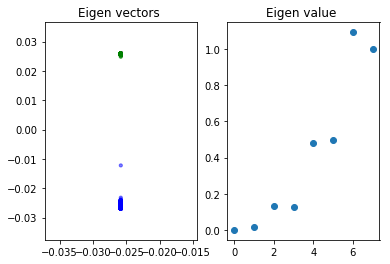

In [124]:
spectral_clustering_showClustering(circle,2,50)